In [107]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

In [131]:
class RNN(tf.Module):
    
    def __init__(self, state_size, batch_size, **kwargs):
        super().__init__(**kwargs)

        # for calculating the next state
        self.w1 = tf.Variable(np.random.rand(state_size + 1, state_size), dtype=tf.float64)
        self.b1 = tf.Variable(np.random.rand(1), dtype=tf.float64)

        # for calculating output
        self.w2 = tf.Variable(np.random.rand(state_size, 1), dtype=tf.float64)
        self.b2 = tf.Variable(np.random.rand(1), dtype=tf.float64)

        self.states = tf.Variable(np.zeros((batch_size, state_size)), shape=(batch_size, state_size))

    # calculate output from current state
    # calcualte next state from current state + input
    # input shap: [batch_size, 1]
    def __call__(self, x):
        input_state_stacked = tf.concat([x, self.states], axis=1)
        output = tf.matmul(self.states, self.w2) + self.b2
        self.states = tf.tanh(tf.matmul(input_state_stacked, self.w1) + self.b1)
        return tf.sigmoid(output)

    def __str__(self):
        return " ".join([str(i) for i in self.state.numpy()])

## Testing

I will generate binary sequences and train a model to create an offset output

In [132]:
# x: batch of sequences (batch_size, sequence length)
def train(model, x, y_actual, learning_rate):

    y_preds = []

    with tf.GradientTape() as tape:
        for point in range(x.shape[1]):
            y_preds.append(model(x[:, point, None]))
            

        y_pred = tf.concat(y_preds, axis = 1)

        current_loss = tf.reduce_mean(tf.square(y_pred - y_actual))

        d_w1, d_b1, d_w2, d_b2 = tape.gradient(current_loss, [model.w1, model.b1, model.w2, model.b2])

        model.w1.assign_sub(learning_rate * d_w1)
        model.b1.assign_sub(learning_rate * d_b1)
        model.w2.assign_sub(learning_rate * d_w2)
        model.b2.assign_sub(learning_rate * d_b2)

    return current_loss

In [133]:
# Define a training loop
def training_loop(model, x, y_actual, epochs, learning_rate, print_every = 1):

    for epoch in range(epochs):

        for batch in range(x.shape[0]):
            # Update the model with the single giant batch
            current_loss = train(model, x[batch, :, :], y_actual[batch, :, :], learning_rate)

            #current_loss = tf.reduce_mean(tf.square(y_actual, model(x))

        if epoch%print_every == 0 or epoch == epochs-1:
            print("Epoch %2d: loss=%2.5f" % (epoch, current_loss))

In [179]:
SEQUENCE_LENGHT = 20
BATCH_SIZE = 100
N_BATCHES = 10
N_EPOCH = 500

X = np.random.choice([0,1], (N_BATCHES, BATCH_SIZE, SEQUENCE_LENGHT), p=[0.5,0.5])
X[:, :, -SHIFT_BY:] = 0
X = tf.constant(X, dtype = tf.dtypes.float64)

SHIFT_BY = 2
y = np.roll(X, SHIFT_BY, axis=2)
y[:, :, :SHIFT_BY] = 0
y = tf.constant(y, dtype = tf.dtypes.float64)

N_STATES = 2
rnn = RNN(N_STATES, BATCH_SIZE)

In [180]:
training_loop(rnn, X, y, N_EPOCH, 0.5, 20)

Epoch  0: loss=0.25463
Epoch 20: loss=0.24794
Epoch 40: loss=0.24776
Epoch 60: loss=0.24766
Epoch 80: loss=0.24758
Epoch 100: loss=0.24752
Epoch 120: loss=0.24746
Epoch 140: loss=0.24741
Epoch 160: loss=0.24736
Epoch 180: loss=0.24731
Epoch 200: loss=0.24726
Epoch 220: loss=0.24719
Epoch 240: loss=0.24709
Epoch 260: loss=0.24693
Epoch 280: loss=0.24657
Epoch 300: loss=0.24389
Epoch 320: loss=0.16602
Epoch 340: loss=0.00724
Epoch 360: loss=0.00186
Epoch 380: loss=0.00106
Epoch 400: loss=0.00074
Epoch 420: loss=0.00056
Epoch 440: loss=0.00046
Epoch 460: loss=0.00038
Epoch 480: loss=0.00033
Epoch 499: loss=0.00029


In [181]:
def plot_data(x, y, batch_index, sequence_index, model = None):
    # plot x to 0.25,
    # plot y to 0.5
    # plot predictions to 1

    plt.plot(x[batch_index, sequence_index, :], label='input')
    plt.plot(y[batch_index, sequence_index, :], label='actual output')

    if model != None:
        preds = []
        states = []
        for index in range(x.shape[2]):
            preds.append(model(x[batch_index, :, index, None])[sequence_index])
            states.append(model.states[sequence_index])
        plt.plot(preds, label='predicted output')
        #plt.plot(states, label='state')

    plt.legend()
    plt.show()

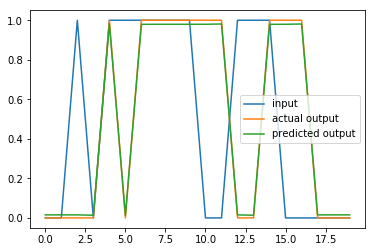

In [182]:
plot_data(X, y, 0, 20, rnn)